In [91]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')
import DNN_torch as dnn
import data_processing as proc
import utils
import performance as perf
import input_feature_engineering as ife
import target_feature_engineering as tfe
import check_features as check_feat

In [258]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])

k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']
k200_df=k200_df.sort_index(0)

<ipython-input-258-4c682375b2e8>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  k200_df=k200_df.sort_index(0)


In [260]:
k200_df.index.get_level_values(0).unique()

DatetimeIndex(['2016-06-02', '2016-06-03', '2016-06-07', '2016-06-08',
               '2016-06-09', '2016-06-10', '2016-06-13', '2016-06-14',
               '2016-06-15', '2016-06-16',
               ...
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30',
               '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03',
               '2023-11-06', '2023-11-07'],
              dtype='datetime64[ns]', name='Dates', length=1826, freq=None)

In [261]:
data_path='../data/output/weight/'
mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)
mlq_w=mlq_w[['code', 'weights']].pivot_table(index='dates', columns='code')
mlq_w.columns=mlq_w.columns.get_level_values(1)

In [262]:
mlq_w.columns, mlq_w.index

(Index(['A000080', 'A000120', 'A000150', 'A000210', 'A000240', 'A000270',
        'A000660', 'A000670', 'A000720', 'A000810',
        ...
        'A323410', 'A326030', 'A329180', 'A336260', 'A352820', 'A373220',
        'A375500', 'A381970', 'A383220', 'A402340'],
       dtype='object', name='code', length=192),
 DatetimeIndex(['2023-02-28', '2023-03-31', '2023-04-28', '2023-05-31',
                '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-27',
                '2023-10-31'],
               dtype='datetime64[ns]', name='dates', freq=None))

In [263]:
period2='2023-10-31'

In [264]:
price=pd.read_parquet('../data/price_data_' + period2 +'.parquet')
price.columns=price.columns.get_level_values(1)

In [265]:
factors=pd.read_parquet('../data/k200_weekly_factor_data_' + period2 + 'v.1.parquet')
indicies=pd.read_parquet('../data/krx_idx_'+ period2 + '.parquet')

In [266]:
price

Symbol,A005930,A000660,A051910,A006400,A005380,A000270,A035420,A005490,A012330,A066570,...,A137310,A271940,A300720,A039130,A381970,A000060,A280360,A175330,A001570,A005420
Dates,,,,,,,,,,,,,,,,,,,,,
2010-01-26,16300.0,23600.0,209500.0,136000.0,108500.0,18600.0,58700.0,572000.0,144000.0,105545.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-27,16000.0,23250.0,207500.0,139500.0,109000.0,18850.0,58072.0,555000.0,144000.0,103591.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-28,16160.0,23600.0,211000.0,141500.0,113500.0,19650.0,57130.0,559000.0,146500.0,107500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-29,15680.0,22750.0,200000.0,136000.0,113000.0,19550.0,54305.0,536000.0,148000.0,106523.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,15540.0,23100.0,204000.0,134000.0,116000.0,20650.0,52893.0,531000.0,150000.0,108477.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,68000.0,127500.0,458000.0,445500.0,182000.0,82000.0,189100.0,445500.0,221000.0,108500.0,...,10310.0,20150.0,12100.0,43150.0,9890.0,NaN,112900.0,10270.0,93000.0,33150.0
2023-10-26,66700.0,120000.0,426000.0,423000.0,179500.0,81000.0,181900.0,421500.0,216000.0,105300.0,...,9820.0,19350.0,11950.0,43700.0,9520.0,NaN,112400.0,10160.0,85600.0,31750.0
2023-10-27,67300.0,119100.0,438500.0,452000.0,175600.0,79700.0,185400.0,423000.0,220000.0,101600.0,...,9690.0,19890.0,12130.0,43450.0,9530.0,NaN,113300.0,10190.0,91200.0,32500.0


In [267]:
factors

Market KOSPI200YN FiscalMonth  NetAmt_InvTrust_20D  \
Dates      Symbol                                                       
2013-01-25 A005930    KSE          Y          12          -21584100.0   
           A000660    KSE          Y          12           -3593610.0   
           A051910    KSE          Y          12           -8616190.0   
           A006400    KSE          Y          12           -6719390.0   
           A005380    KSE          Y          12           -2665260.0   
...                   ...        ...         ...                  ...   
2023-10-31 A003850    KSE          Y          12             -16239.0   
           A020000    KSE          Y          12                781.0   
           A013890    KSE          Y          12              22769.0   
           A057050    KSE          Y          12               5938.0   
           A284740    KSE          Y          12             -22545.0   

                    NetAmt_InvTrust_60D  NetAmt_InvTrust_120D  \
Dates      Symbol                                               
2013-01-25 A005930          -34755700.0          -114100000.0   
           A000660           -7703350.0            -6271160.0   
           A051910            2354980.0           -14595800.0   
           A006400           -6584750.0            -7214190.0   
           A005380           -5454920.0           -42011100.0   
...                                 ...                   ...   
2023-10-31 A003850             130270.0              -98541.0   
           A020000              18945.0             -158724.0   
           A013890              56206.0                4331.0   
           A057050            -308460.0             -240696.0   
           A284740            -158234.0             -197050.0   

                    NetAmt_Inst_20D  NetAmt_Inst_60D  NetAmt_Inst_120D  \
Dates      Symbol                                                        
2013-01-25 A005930      -34335600.0       37638000.0       -27817700.0   
           A000660      -16403500.0       -4609360.0        14809500.0   
           A051910      -11182300.0        8053860.0       -13403100.0   
           A006400      -12050800.0      -16984700.0       -19466300.0   
           A005380       14031600.0        7443980.0       -22832600.0   
...                             ...              ...               ...   
2023-10-31 A003850         114240.0         842530.0          579139.0   
           A020000         123370.0         157467.0         -920075.0   
           A013890         -23114.0         125012.0          -42265.0   
           A057050          43464.0        -390132.0         -408174.0   
           A284740         -76526.0        -362599.0         -500004.0   

                    NetAmt_For_20D  ...  trA_60avg_spot  adjMomentum  \
Dates      Symbol                   ...                                
2013-01-25 A005930     -49473900.0  ...    3.906866e+11   -14.289699   
           A000660        458935.0  ...    1.233964e+11    -1.253230   
           A051910       2274220.0  ...    6.540141e+10     0.004449   
           A006400       8319870.0  ...    2.875826e+10     0.221259   
           A005380     -26310900.0  ...    1.594079e+11    -0.665268   
...                            ...  ...             ...          ...   
2023-10-31 A003850        172414.0  ...    4.501184e+09    -0.006691   
           A020000       -136897.0  ...    1.725658e+09     0.341629   
           A013890         42833.0  ...    1.238491e+09     0.094132   
           A057050       -127506.0  ...    6.654622e+08     0.725905   
           A284740         51516.0  ...    1.267836e+09          NaN   

                   earningYield    growth  momentum  priceReversal  \
Dates      Symbol                                                    
2013-01-25 A005930    57.989559  0.436903  0.153347      51.552576   
           A000660    -6.241009  9.127211  0.213254       1.020661   
           A051910    48.556603  0.061439 -

In [268]:
indicies

,코스피,코스피 200,코스피 100,코스피 50,코스닥 150,코스닥,코스피 200 동일가중,코스피 대형주,코스피 중형주,코스피 소형주,...,코스피 200 철강소재 TR,코스피 200 에너지화학 TR,코스피 200 정보기술 TR,코스피 200 금융 TR,코스피 200 생활소비재 TR,코스피 200 경기소비재 TR,코스피 200 산업재 TR,코스피 200 헬스케어 TR,코스피 200 커뮤니케이션서비스 TR,코스피 200 ESG 지수
Symbol Name,,,,,,,,,,,,,,,,,,,,,
2000-01-04,1059.04,133.66,NaN,NaN,NaN,2660.00,NaN,1000.00,1000.00,1000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,986.31,123.86,922.14,918.40,NaN,2629.50,NaN,923.61,970.47,992.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,960.79,120.80,900.82,898.72,NaN,2475.20,NaN,904.64,931.49,962.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,948.65,119.10,887.78,883.90,NaN,2276.60,NaN,890.32,938.66,966.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,987.24,124.11,927.12,924.83,NaN,2310.80,NaN,928.70,952.01,975.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,2363.17,316.49,2386.90,2190.87,1208.41,770.84,1953.78,2352.08,2591.65,2201.72,...,1093.66,1583.86,3515.45,943.59,986.87,1762.52,633.90,1664.86,1961.49,345.97
2023-10-26,2299.08,307.75,2320.67,2127.36,1160.79,743.85,1906.91,2287.42,2523.50,2153.57,...,1056.94,1518.78,3356.98,928.76,975.00,1732.71,614.47,1643.91,1901.78,336.05
2023-10-27,2302.81,308.53,2326.35,2133.09,1175.63,748.49,1907.21,2291.81,2525.93,2151.24,...,1052.65,1539.19,3378.14,918.93,958.51,1725.75,614.79,1641.18,1927.44,336.96


In [269]:
f_size=['size']
f_dividend=['dividend']
f_prcMom=['priceMomentum']
f_tradVol=['trading']
f_invSent=['investSentiment']
f_earninYield=['epsF_p', 'earningsOtmv']
f_prcRev=['52H/p_Mom', '52L/p_Mom']
f_stability=['dtoequity', 'deltaDtoEquityYoY']
f_priceStdev=['stStevOLtStdev', 'Vol_20D', 'Vol_120D']
f_quality=['roeF_proxy', 'roeT_proxy', 'roeQ']
f_adjMom=['dEpsOp', 'rAdjdEpsOp']
f_mom=['roeFTMom', 'epsFMom', 'salseFMom', 'roeFchg_proxy', 'slsAdjEarningsYOY', 'sprsEarningsOearningsAvgPstdev']
f_growth=['epsFTMom', 'earningsFTMom', 'earningsYOY', 'salesYOY', 'cashFlowYOY']
f_value=['salesOtmv', 'cashFlowOtmv', 'equityOtmv', 'bpsF_p', 'bpsT_p', 'spsF_p', 'spsT_p', 'cfpsF_p']

In [270]:
factor_ls=[f_size, f_dividend, f_prcMom, f_tradVol, f_invSent, f_earninYield, f_prcRev, f_stability, f_priceStdev,
           f_quality, f_adjMom, f_mom, f_growth, f_value]
factor_name_ls=['size', 'dividend', 'prcMom', 'tradVol', 'invSent', 'earninYield', 'prcRev', 'stability',
                'priceStdev', 'quality', 'adjMom', 'mom', 'growth', 'value']

In [271]:
len(factor_ls)

14

In [272]:
factor_dates=factors.index.get_level_values(0).unique()
factor_dates=pd.to_datetime(factor_dates)

In [273]:
factors.index.get_level_values(0).unique()[factors.index.get_level_values(0).unique() > '2023-05-20']

DatetimeIndex(['2023-05-26', '2023-06-02', '2023-06-09', '2023-06-16',
               '2023-06-23', '2023-06-30', '2023-07-07', '2023-07-14',
               '2023-07-21', '2023-07-28', '2023-08-04', '2023-08-11',
               '2023-08-18', '2023-08-25', '2023-09-01', '2023-09-08',
               '2023-09-15', '2023-09-22', '2023-09-27', '2023-10-06',
               '2023-10-13', '2023-10-20', '2023-10-27', '2023-10-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [274]:
factors

Market KOSPI200YN FiscalMonth  NetAmt_InvTrust_20D  \
Dates      Symbol                                                       
2013-01-25 A005930    KSE          Y          12          -21584100.0   
           A000660    KSE          Y          12           -3593610.0   
           A051910    KSE          Y          12           -8616190.0   
           A006400    KSE          Y          12           -6719390.0   
           A005380    KSE          Y          12           -2665260.0   
...                   ...        ...         ...                  ...   
2023-10-31 A003850    KSE          Y          12             -16239.0   
           A020000    KSE          Y          12                781.0   
           A013890    KSE          Y          12              22769.0   
           A057050    KSE          Y          12               5938.0   
           A284740    KSE          Y          12             -22545.0   

                    NetAmt_InvTrust_60D  NetAmt_InvTrust_120D  \
Dates      Symbol                                               
2013-01-25 A005930          -34755700.0          -114100000.0   
           A000660           -7703350.0            -6271160.0   
           A051910            2354980.0           -14595800.0   
           A006400           -6584750.0            -7214190.0   
           A005380           -5454920.0           -42011100.0   
...                                 ...                   ...   
2023-10-31 A003850             130270.0              -98541.0   
           A020000              18945.0             -158724.0   
           A013890              56206.0                4331.0   
           A057050            -308460.0             -240696.0   
           A284740            -158234.0             -197050.0   

                    NetAmt_Inst_20D  NetAmt_Inst_60D  NetAmt_Inst_120D  \
Dates      Symbol                                                        
2013-01-25 A005930      -34335600.0       37638000.0       -27817700.0   
           A000660      -16403500.0       -4609360.0        14809500.0   
           A051910      -11182300.0        8053860.0       -13403100.0   
           A006400      -12050800.0      -16984700.0       -19466300.0   
           A005380       14031600.0        7443980.0       -22832600.0   
...                             ...              ...               ...   
2023-10-31 A003850         114240.0         842530.0          579139.0   
           A020000         123370.0         157467.0         -920075.0   
           A013890         -23114.0         125012.0          -42265.0   
           A057050          43464.0        -390132.0         -408174.0   
           A284740         -76526.0        -362599.0         -500004.0   

                    NetAmt_For_20D  ...  trA_60avg_spot  adjMomentum  \
Dates      Symbol                   ...                                
2013-01-25 A005930     -49473900.0  ...    3.906866e+11   -14.289699   
           A000660        458935.0  ...    1.233964e+11    -1.253230   
           A051910       2274220.0  ...    6.540141e+10     0.004449   
           A006400       8319870.0  ...    2.875826e+10     0.221259   
           A005380     -26310900.0  ...    1.594079e+11    -0.665268   
...                            ...  ...             ...          ...   
2023-10-31 A003850        172414.0  ...    4.501184e+09    -0.006691   
           A020000       -136897.0  ...    1.725658e+09     0.341629   
           A013890         42833.0  ...    1.238491e+09     0.094132   
           A057050       -127506.0  ...    6.654622e+08     0.725905   
           A284740         51516.0  ...    1.267836e+09          NaN   

                   earningYield    growth  momentum  priceReversal  \
Dates      Symbol                                                    
2013-01-25 A005930    57.989559  0.436903  0.153347      51.552576   
           A000660    -6.241009  9.127211  0.213254       1.020661   
           A051910    48.556603  0.061439 -

In [275]:
idxw=k200_df['idx_weight'].unstack()

In [276]:
num_stocks=70
bm_name='코스피 200'
start_date='2023-02-01'
end_date=period2

In [277]:
temp_factor_dates=factor_dates[(factor_dates>=start_date) & (factor_dates<=end_date)]
rebal_dates=proc.find_entire_rebalancing_dates(temp_factor_dates)


lack of the beginning part of data  2023-01-31 00:00:00 2023-02-03 00:00:00
expected date is not in inner dates 2023-02-28 00:00:00
2023-02-28 00:00:00 2023-02-24 00:00:00
expected date is not in inner dates 2023-04-30 00:00:00
2023-04-30 00:00:00 2023-04-28 00:00:00
expected date is not in inner dates 2023-05-31 00:00:00
2023-05-31 00:00:00 2023-05-26 00:00:00
expected date is not in inner dates 2023-07-31 00:00:00
2023-07-31 00:00:00 2023-07-28 00:00:00
expected date is not in inner dates 2023-08-31 00:00:00
2023-08-31 00:00:00 2023-08-25 00:00:00
expected date is not in inner dates 2023-09-30 00:00:00
2023-09-30 00:00:00 2023-09-27 00:00:00


/home/hyungshin.lee/analysis/../py/data_processing.py:299: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  temp_idx = inner_dates.get_loc(expected_rebal_dates[i], method='ffill')


In [278]:
rebal_dates

[Timestamp('2023-02-24 00:00:00'),
 Timestamp('2023-03-31 00:00:00', freq='M'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-05-26 00:00:00'),
 Timestamp('2023-06-30 00:00:00', freq='M'),
 Timestamp('2023-07-28 00:00:00'),
 Timestamp('2023-08-25 00:00:00'),
 Timestamp('2023-09-27 00:00:00'),
 Timestamp('2023-10-31 00:00:00', freq='M')]

In [279]:
def factor_performance(factor_slice, num_stocks, bm_name, price, indicies):
    factor_slice=factor_slice.unstack()
    if isinstance(factor_slice.columns, pd.MultiIndex):
        factor_slice.columns=factor_slice.columns.get_level_values(1)
        
    factor_slice=factor_slice.rank(1, ascending=False)
    factor_slice[factor_slice<=num_stocks]=1/num_stocks
    factor_slice[factor_slice>num_stocks]=0.0
    factor_slice=factor_slice.fillna(0)
    
    port_df=pd.DataFrame(None, index=price.index, columns=price.columns)
    port_df.loc[factor_slice.index, factor_slice.columns]=factor_slice
    port_df=port_df.fillna(method='ffill').dropna(how='all', axis=0)
    daily_ret=(port_df*price.pct_change().loc[port_df.index, port_df.columns]).sum(1)
    bm_ret=indicies[bm_name].pct_change().loc[daily_ret.index]
    excess_ret=((1+daily_ret-bm_ret).cumprod()-1)

    return excess_ret

def factor_scaler(factor_slice, idx_weight):
    # 1. find ranking for each factor in the universe
    # 2. then zscore
    # 3. multiply zscore * weight of stocks in strategy

    unstacked=factor_slice.unstack()
    if isinstance(unstacked.columns, pd.MultiIndex):
        unstacked.columns=unstacked.columns.get_level_values(1)
        
    unstacked=unstacked.replace([np.inf, -np.inf], None)
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(unstacked.T)
    scaled_df=pd.DataFrame(scaled, columns=unstacked.index, index= unstacked.columns)
    scaled_df=scaled_df.T
    return (scaled_df*idx_weight).dropna(how='all').sum(1)

In [281]:
temp_factor_dates=factors.index.get_level_values(0).unique()
temp_factor_dates[temp_factor_dates.isin(rebal_dates)]

DatetimeIndex(['2023-02-24', '2023-03-31', '2023-04-28', '2023-05-26',
               '2023-06-30', '2023-07-28', '2023-08-25', '2023-09-27',
               '2023-10-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [297]:
port_w=mlq_w # idxw/100, mlq_w

factor_score_ls=[]
factor_performance_ls=[]
for f in factor_ls:
    if len(f)>1:
        sub_factor_perf_ls=[]
        sub_factor_score_ls=[]
        for sub_f in range(len(f)):
            factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f[sub_f]]
            sub_factor_perf_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
            sub_factor_score_ls.append(factor_scaler(factor_slice, port_w))
            
        factor_performance_ls.append(pd.concat(sub_factor_perf_ls, axis=1).mean(1))
        factor_score_ls.append(pd.concat(sub_factor_score_ls, axis=1).mean(1))
        
    else:
        factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f]
        factor_performance_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
        factor_score_ls.append(factor_scaler(factor_slice, port_w))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [298]:
port_w

code,A000080,A000120,A000150,A000210,A000240,A000270,A000660,A000670,A000720,A000810,...,A323410,A326030,A329180,A336260,A352820,A373220,A375500,A381970,A383220,A402340
dates,,,,,,,,,,,,,,,,,,,,,
2023-02-28,NaN,0.009461,0.009461,NaN,NaN,NaN,NaN,NaN,0.009461,0.009461,...,NaN,0.009461,0.009461,0.009461,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,NaN,NaN,NaN,NaN,NaN,0.011639,0.011639,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28,NaN,NaN,0.009329,NaN,NaN,NaN,0.009329,0.009329,NaN,NaN,...,0.009329,0.009329,0.009329,0.009329,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009372,NaN,NaN,...,NaN,0.009372,0.009372,0.009372,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-30,NaN,NaN,0.009192,NaN,NaN,0.009192,NaN,0.009192,NaN,NaN,...,0.009192,0.009192,0.009192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31,NaN,0.009419,NaN,NaN,NaN,NaN,0.009419,0.009419,NaN,NaN,...,0.009419,0.009419,0.009419,NaN,0.009419,0.009419,NaN,NaN,NaN,0.009419
2023-08-31,0.009463,0.009463,NaN,0.009463,0.009463,0.009463,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009463,NaN,0.009463,NaN
2023-09-27,0.009396,0.009396,NaN,0.009396,0.009396,0.009396,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009396,0.009396,0.009396,NaN
2023-10-31,0.009396,0.009396,0.009396,0.009396,0.009396,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009396,0.009396,0.009396,NaN


In [299]:
factor_slice.index.get_level_values(0).unique()

DatetimeIndex(['2023-02-24', '2023-03-31', '2023-04-28', '2023-05-26',
               '2023-06-30', '2023-07-28', '2023-08-25', '2023-09-27',
               '2023-10-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [300]:
factor_slice

Dates       Symbol 
2023-02-24  A005930    9.863404
            A373220    0.089136
            A000660    0.914573
            A207940    0.014816
            A051910    0.096841
                         ...   
2023-10-31  A003850    0.102514
            A020000    0.090006
            A013890    0.034996
            A057050    0.041995
            A284740         NaN
Name: cfpsF_p, Length: 1800, dtype: float64

In [301]:
bm_w=idxw/100 # idxw/100, mlq_w

factor_score_bm_ls=[]
factor_performance_bm_ls=[]
for f in factor_ls:
    if len(f)>1:
        sub_factor_perf_bm_ls=[]
        sub_factor_score_bm_ls=[]
        for sub_f in range(len(f)):
            factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f[sub_f]]
            sub_factor_perf_bm_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
            sub_factor_score_bm_ls.append(factor_scaler(factor_slice, bm_w))
            
        factor_performance_bm_ls.append(pd.concat(sub_factor_perf_bm_ls, axis=1).mean(1))
        factor_score_bm_ls.append(pd.concat(sub_factor_score_bm_ls, axis=1).mean(1))
    else:
        factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f]
        factor_performance_bm_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
        factor_score_bm_ls.append(factor_scaler(factor_slice, bm_w))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [302]:
bm_w

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A336260,A352820,A361610,A373220,A375500,A377300,A381970,A383220,A383800,A402340
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.0046,0.0003,NaN,0.001,0.0012,0.0039,0.0028,0.0001,0.0010,0.0034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.0045,0.0003,NaN,0.001,0.0011,0.0040,0.0029,0.0001,0.0011,0.0033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.0045,0.0003,NaN,0.001,0.0011,0.0039,0.0030,0.0001,0.0010,0.0034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.0045,0.0003,NaN,0.001,0.0011,0.0040,0.0030,0.0001,0.0010,0.0034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.0044,0.0003,NaN,0.001,0.0011,0.0039,0.0029,0.0002,0.0011,0.0034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,NaN,NaN,NaN,NaN,0.0007,0.0033,0.0008,NaN,0.0005,0.0005,...,0.0006,0.0064,0.0015,0.0132,0.001,0.0024,0.0001,0.0015,NaN,0.0041
2023-11-02,NaN,NaN,NaN,NaN,0.0006,0.0033,0.0008,NaN,0.0005,0.0005,...,0.0007,0.0062,0.0016,0.0134,0.001,0.0025,0.0001,0.0014,NaN,0.0042
2023-11-03,NaN,NaN,NaN,NaN,0.0006,0.0033,0.0008,NaN,0.0005,0.0005,...,0.0007,0.0058,0.0017,0.0136,0.001,0.0026,0.0001,0.0014,NaN,0.0042


In [303]:
# port_w=mlq_w # idxw/100, mlq_w
# bm_w=idxw/100 # idxw/100, mlq_w


# factor_score_ls=[]
# factor_performance_ls=[]

# factor_score_bm_ls=[]
# factor_performance_bm_ls=[]

# for f in factor_ls:
#     if len(f)>1:
#         sub_factor_perf_ls=[]
#         sub_factor_score_ls=[]
        
#         sub_factor_perf_bm_ls=[]
#         sub_factor_score_bm_ls=[]
        
#         for sub_f in range(len(f)):
#             factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f[sub_f]]
#             sub_factor_perf_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))

#             sub_factor_score_ls.append(factor_scaler(factor_slice, port_w))
#             sub_factor_score_bm_ls.append(factor_scaler(factor_slice, bm_w))

            
#         factor_performance_ls.append(pd.concat(sub_factor_perf_ls, axis=1).mean(1))
#         factor_score_ls.append(pd.concat(sub_factor_score_ls, axis=1).mean(1))        
#         factor_score_bm_ls.append(pd.concat(sub_factor_score_bm_ls, axis=1).mean(1))
        
        
#     else:
#         factor_slice=factors.loc[factors.index.get_level_values(0).isin(rebal_dates), f]
#         factor_performance_ls.append(factor_performance(factor_slice, num_stocks, bm_name, price, indicies))
#         factor_score_ls.append(factor_scaler(factor_slice, port_w))

In [304]:
factor_slice.index.get_level_values(0).unique()

DatetimeIndex(['2023-02-24', '2023-03-31', '2023-04-28', '2023-05-26',
               '2023-06-30', '2023-07-28', '2023-08-25', '2023-09-27',
               '2023-10-31'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [305]:
unstacked=factor_slice.unstack()


In [306]:
unstacked

Symbol,A005930,A373220,A000660,A207940,A051910,A006400,A005380,A000270,A035420,A005490,...,A057050,A284740,A241590,A005440,A008560,A139130,A003230,A001570,A005420,A008730
Dates,,,,,,,,,,,,,,,,,,,,,
2023-02-24,9.863404,0.089136,0.914573,0.014816,0.096841,0.058697,0.762857,1.190829,0.085892,0.224579,...,0.041545,NaN,0.148732,0.221149,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,9.012980,0.078506,0.852206,0.014593,0.090938,0.055270,0.722569,1.118307,0.088798,0.199485,...,0.045086,NaN,0.178083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28,8.867315,0.092508,0.925294,0.015403,0.096943,0.058594,0.790605,1.259505,0.093966,0.192302,...,0.039903,NaN,0.167268,NaN,NaN,NaN,0.010452,NaN,NaN,NaN
2023-05-26,8.340515,0.097074,0.825937,0.015847,0.105878,0.060004,0.762705,1.219892,0.088712,0.202633,...,0.037085,NaN,0.186286,NaN,NaN,NaN,0.011101,NaN,NaN,NaN
2023-06-30,8.560262,0.105106,0.975181,0.016695,0.117625,0.062967,0.765574,1.233006,0.099314,0.188873,...,0.038335,NaN,NaN,NaN,NaN,NaN,0.011257,NaN,NaN,NaN
2023-07-28,9.212569,0.108333,1.019096,0.016278,0.114323,0.064416,0.866377,1.390535,0.089041,0.120943,...,0.039576,NaN,NaN,NaN,NaN,NaN,0.010559,NaN,NaN,NaN
2023-08-25,9.942279,0.111350,1.208524,0.016991,0.133502,0.072876,0.917170,1.497127,0.089500,0.130829,...,0.043268,NaN,NaN,NaN,NaN,NaN,0.007462,NaN,NaN,NaN
2023-09-27,9.915896,0.129343,1.336844,0.019164,0.156059,0.085756,0.899725,1.435615,0.095177,0.139170,...,0.041866,NaN,NaN,NaN,NaN,NaN,0.007115,NaN,NaN,NaN
2023-10-31,9.894850,0.150002,1.427920,0.019139,0.168709,0.100423,1.012055,1.515998,0.104327,0.168732,...,0.041995,NaN,NaN,NaN,NaN,NaN,0.008241,NaN,NaN,NaN


In [307]:
if isinstance(unstacked.columns, pd.MultiIndex):
    unstacked.columns=unstacked.columns.get_level_values(1)

unstacked=unstacked.replace([np.inf, -np.inf], None)


In [308]:

scaler = StandardScaler()
scaled = scaler.fit_transform(unstacked.T)


In [309]:
scaled

array([[10.70270358, 10.15361006, 10.06338628, ...,  9.39967128,
         9.26533918,  8.9597541 ],
       [-0.25845919, -0.28183331, -0.26744271, ..., -0.24859365,
        -0.22331063, -0.22451667],
       [ 0.6672107 ,  0.62184592,  0.71301971, ...,  0.82819483,
         0.94743343,  0.979888  ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [310]:
scaled_df=pd.DataFrame(scaled, columns=unstacked.index, index= unstacked.columns)
scaled_df=scaled_df.T


In [311]:
scaled_df

Symbol,A005930,A373220,A000660,A207940,A051910,A006400,A005380,A000270,A035420,A005490,...,A057050,A284740,A241590,A005440,A008560,A139130,A003230,A001570,A005420,A008730
Dates,,,,,,,,,,,,,,,,,,,,,
2023-02-24,10.702704,-0.258459,0.667211,-0.341804,-0.249818,-0.292594,0.497072,0.977013,-0.262097,-0.106570,...,-0.311829,NaN,-0.191627,-0.110416,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,10.153610,-0.281833,0.621846,-0.356484,-0.267313,-0.308973,0.470431,0.932652,-0.269812,-0.140531,...,-0.320868,NaN,-0.165528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28,10.063386,-0.267443,0.713020,-0.358221,-0.262221,-0.307371,0.554446,1.106496,-0.265726,-0.149953,...,-0.329376,NaN,-0.179425,NaN,NaN,NaN,-0.364049,NaN,NaN,NaN
2023-05-26,9.576308,-0.275586,0.595492,-0.372662,-0.265064,-0.319890,0.519921,1.066315,-0.285580,-0.149431,...,-0.347280,NaN,-0.168968,NaN,NaN,NaN,-0.378335,NaN,NaN,NaN
2023-06-30,9.652171,-0.261425,0.758730,-0.365086,-0.246747,-0.310833,0.512967,1.061027,-0.268216,-0.163209,...,-0.339713,NaN,NaN,NaN,NaN,NaN,-0.371462,NaN,NaN,NaN
2023-07-28,9.416477,-0.252534,0.714728,-0.350300,-0.246173,-0.299176,0.552534,1.109209,-0.273023,-0.239142,...,-0.325557,NaN,NaN,NaN,NaN,NaN,-0.356374,NaN,NaN,NaN
2023-08-25,9.399671,-0.248594,0.828195,-0.341199,-0.226853,-0.286353,0.542254,1.111435,-0.270037,-0.229476,...,-0.315410,NaN,NaN,NaN,NaN,NaN,-0.350551,NaN,NaN,NaN
2023-09-27,9.265339,-0.223311,0.947433,-0.330136,-0.197409,-0.265571,0.523620,1.043198,-0.256437,-0.213783,...,-0.308125,NaN,NaN,NaN,NaN,NaN,-0.341818,NaN,NaN,NaN
2023-10-31,8.959754,-0.224517,0.979888,-0.347852,-0.206886,-0.271243,0.587947,1.062899,-0.267564,-0.206864,...,-0.326311,NaN,NaN,NaN,NaN,NaN,-0.358123,NaN,NaN,NaN


In [312]:
(scaled_df*port_w).dropna(how='all').sum(1)

2023-03-31    3.056120
2023-04-28    2.861089
2023-06-30    3.035646
2023-09-27    2.814198
2023-10-31    2.701686
dtype: float64

In [313]:
factor_scaler(factor_slice, port_w)

2023-03-31    3.056120
2023-04-28    2.861089
2023-06-30    3.035646
2023-09-27    2.814198
2023-10-31    2.701686
dtype: float64

In [314]:
factor_res=pd.concat(factor_performance_ls, axis=1)
factor_res.columns=factor_name_ls

factor_score_res=pd.concat(factor_score_ls, axis=1)
factor_score_res.columns=factor_name_ls

factor_score_bm_res=pd.concat(factor_score_bm_ls, axis=1)
factor_score_bm_res.columns=factor_name_ls

In [315]:
factor_score_diff=factor_score_res - factor_score_bm_res

In [316]:
factor_score_res

,size,dividend,prcMom,tradVol,invSent,earninYield,prcRev,stability,priceStdev,quality,adjMom,mom,growth,value
2023-03-31,1.320813,-0.214633,-0.084182,0.071456,-0.022319,-0.239693,-0.058476,-0.015318,0.118096,-0.205591,-1.579623,-0.145626,-0.125148,0.753939
2023-04-28,1.240476,-0.346382,0.174745,0.296674,0.082503,-0.385057,0.095574,-0.132080,0.233817,-0.207899,-0.962604,-0.088770,-0.032126,0.595544
2023-06-30,1.462269,NaN,0.208085,-0.176292,-0.038937,-0.386782,-0.039661,-0.121409,-0.135948,-0.173356,-1.650241,0.004532,0.007164,0.611709
2023-09-27,1.012707,0.166323,-0.179902,0.354865,-0.008252,0.237862,0.002154,0.012716,-0.123319,0.143537,-2.074506,-0.086385,-0.190124,0.853600
2023-10-31,0.967453,0.161439,-0.059942,0.201817,-0.079347,0.208503,-0.330148,-0.003825,-0.326320,0.108207,-2.278019,-0.045776,-0.149514,0.795578


In [317]:
factor_score_bm_res

,size,dividend,prcMom,tradVol,invSent,earninYield,prcRev,stability,priceStdev,quality,adjMom,mom,growth,value
Dates,,,,,,,,,,,,,,
2023-02-24,2.100645,-0.096268,0.244963,0.051377,0.055443,-0.205732,0.020062,-0.020139,-0.032097,-0.076041,-1.530097,-0.128986,-0.139652,0.736493
2023-03-31,2.144648,-0.107009,0.257260,-0.143510,0.087251,-0.238385,-0.077967,-0.029490,-0.215473,-0.069163,-1.653935,-0.150052,-0.152714,0.678026
2023-04-28,2.139781,-0.106559,0.304576,0.064658,0.151234,-0.238603,-0.009913,-0.075034,-0.153681,-0.048002,-1.169053,-0.060413,-0.143256,0.684746
2023-05-26,2.204207,-0.115269,0.280843,0.099876,0.198853,-0.259259,-0.251646,-0.112447,-0.346000,-0.069480,-1.280793,-0.022854,-0.142837,0.659865
2023-06-30,2.218668,NaN,0.174946,-0.137319,0.044975,-0.276361,-0.171925,-0.128715,-0.414381,-0.143810,-1.792513,-0.045839,-0.145195,0.686153
2023-07-28,2.174457,NaN,0.183879,0.021468,0.104496,-0.271432,0.038319,-0.129202,-0.189106,-0.139207,-1.673824,0.045928,-0.126908,0.615453
2023-08-25,2.156028,-0.098679,0.321661,-0.117489,-0.009985,-0.235189,-0.089545,-0.100308,-0.342397,-0.141090,-1.841757,-0.030449,-0.123685,0.622490
2023-09-27,2.172032,-0.078184,0.197880,0.277454,-0.029981,-0.244870,0.003462,-0.093298,-0.075692,-0.163543,-2.082783,-0.052779,-0.129476,0.642563
2023-10-31,2.251052,-0.074763,0.285136,0.324512,-0.033944,-0.244114,-0.141384,-0.099644,-0.256576,-0.180365,-2.459613,-0.026475,-0.148913,0.648680


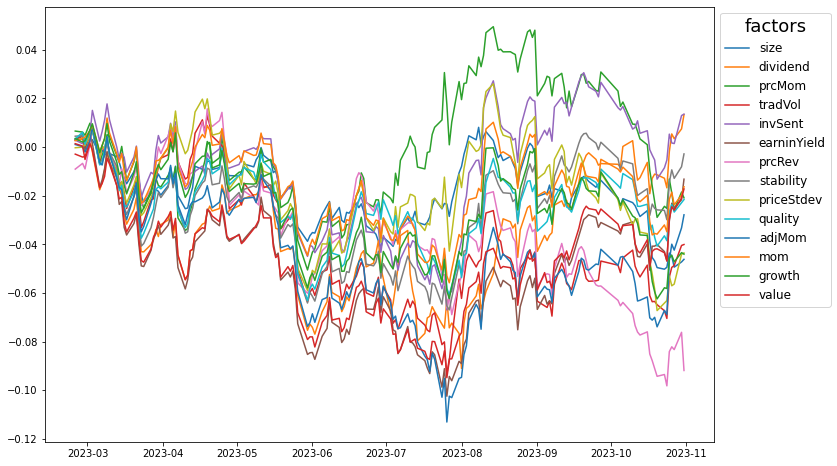

In [319]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.plot(factor_res.index, factor_res)

ax1.legend(labels = factor_res.columns,
      fontsize = 12,
      title = "factors",
      title_fontsize = 18)
ax1.legend_.set_bbox_to_anchor([1, 1])
    

In [321]:
factor_score_diff.dropna()

,size,dividend,prcMom,tradVol,invSent,earninYield,prcRev,stability,priceStdev,quality,adjMom,mom,growth,value
2023-03-31,-0.823835,-0.107625,-0.341442,0.214966,-0.109570,-0.001308,0.019490,0.014171,0.333569,-0.136428,0.074312,0.004426,0.027566,0.075913
2023-04-28,-0.899305,-0.239823,-0.129831,0.232017,-0.068731,-0.146454,0.105487,-0.057046,0.387498,-0.159897,0.206449,-0.028357,0.111129,-0.089202
2023-09-27,-1.159325,0.244506,-0.377782,0.077411,0.021729,0.482732,-0.001309,0.106014,-0.047627,0.307079,0.008277,-0.033606,-0.060648,0.211037
2023-10-31,-1.283598,0.236201,-0.345078,-0.122694,-0.045403,0.452617,-0.188764,0.095819,-0.069744,0.288571,0.181594,-0.019301,-0.000601,0.146898


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


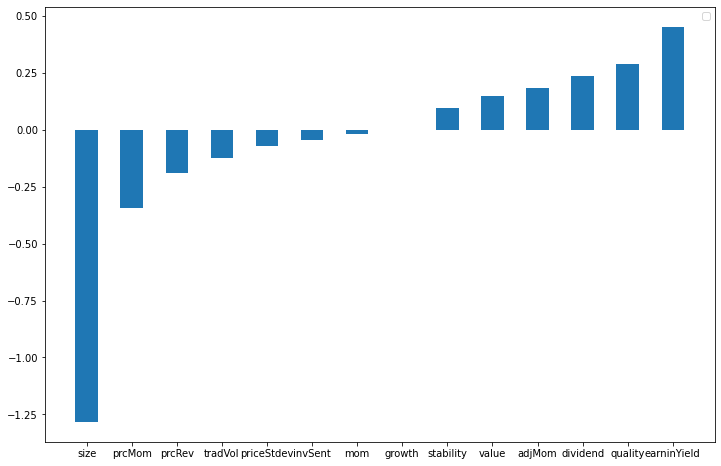

In [322]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.bar(factor_score_diff.dropna().iloc[-1].sort_values().index, factor_score_diff.dropna().iloc[-1].sort_values(), .5)

# ax1.legend(labels = factor_res.columns,
#       fontsize = 12,
#       title = "factors",
#       title_fontsize = 18)
# ax1.legend_.set_bbox_to_anchor([1, 1])
plt.legend()    

In [226]:
factor_score_diff

,size,dividend,prcMom,tradVol,invSent,earninYield,prcRev,stability,priceStdev,quality,adjMom,mom,growth,value
2023-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,-0.823835,-0.107625,-0.341442,0.214966,-0.109570,-0.001308,0.019490,0.014171,0.333569,-0.136428,0.074312,0.004426,0.027566,0.075913
2023-04-28,-0.899305,-0.239823,-0.129831,0.232017,-0.068731,-0.146454,0.105487,-0.057046,0.387498,-0.159897,0.206449,-0.028357,0.111129,-0.089202
2023-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-30,-0.756399,NaN,0.033138,-0.038973,-0.083913,-0.110421,0.132264,0.007305,0.278433,-0.029546,0.142272,0.050371,0.152359,-0.074444
2023-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,-1.159325,0.244506,-0.377782,0.077411,0.021729,0.482732,-0.001309,0.106014,-0.047627,0.307079,0.008277,-0.033606,-0.060648,0.211037
2023-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
factor_score_diff.iloc[-1].sort_values(ascending=False).to_frame()

,2023-10-31
earninYield,0.452617
quality,0.288571
dividend,0.236201
adjMom,0.181594
value,0.146898
stability,0.095819
growth,-0.000601
mom,-0.019301
invSent,-0.045403
priceStdev,-0.069744


In [217]:
idxw.sum(1)

Dates
2016-06-02    100.03
2016-06-03    100.04
2016-06-07    100.05
2016-06-08    100.05
2016-06-09    100.02
               ...  
2023-10-24     99.95
2023-10-25     99.96
2023-10-26    100.03
2023-10-27     99.98
2023-10-30     99.92
Length: 1820, dtype: float64

In [218]:
factor_score_res=pd.concat(factor_score_ls, axis=1)
factor_score_res.columns=factor_name_ls

In [219]:
factor_score_res.mean()

size           1.200744
dividend      -0.058313
prcMom         0.011761
tradVol        0.149704
invSent       -0.013270
earninYield   -0.113033
prcRev        -0.066112
stability     -0.051983
priceStdev    -0.046735
quality       -0.067020
adjMom        -1.708999
mom           -0.072405
growth        -0.097950
value          0.722074
dtype: float64

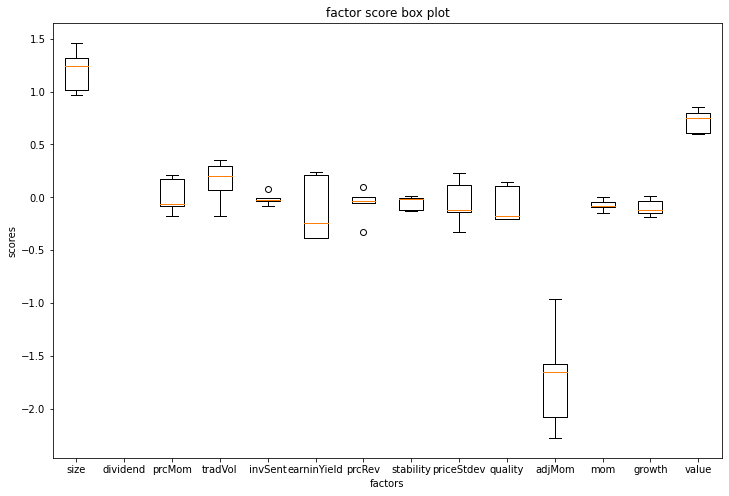

In [220]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.boxplot(factor_score_res, labels=factor_score_res.columns)

plt.xlabel('factors')
plt.ylabel('scores')
plt.title('factor score box plot')
plt.show()

In [221]:
port_w

code,A000080,A000120,A000150,A000210,A000240,A000270,A000660,A000670,A000720,A000810,...,A323410,A326030,A329180,A336260,A352820,A373220,A375500,A381970,A383220,A402340
dates,,,,,,,,,,,,,,,,,,,,,
2023-02-28,NaN,0.009461,0.009461,NaN,NaN,NaN,NaN,NaN,0.009461,0.009461,...,NaN,0.009461,0.009461,0.009461,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,NaN,NaN,NaN,NaN,NaN,0.011639,0.011639,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28,NaN,NaN,0.009329,NaN,NaN,NaN,0.009329,0.009329,NaN,NaN,...,0.009329,0.009329,0.009329,0.009329,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009372,NaN,NaN,...,NaN,0.009372,0.009372,0.009372,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-30,NaN,NaN,0.009192,NaN,NaN,0.009192,NaN,0.009192,NaN,NaN,...,0.009192,0.009192,0.009192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31,NaN,0.009419,NaN,NaN,NaN,NaN,0.009419,0.009419,NaN,NaN,...,0.009419,0.009419,0.009419,NaN,0.009419,0.009419,NaN,NaN,NaN,0.009419
2023-08-31,0.009463,0.009463,NaN,0.009463,0.009463,0.009463,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009463,NaN,0.009463,NaN
2023-09-27,0.009396,0.009396,NaN,0.009396,0.009396,0.009396,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009396,0.009396,0.009396,NaN
2023-10-31,0.009396,0.009396,0.009396,0.009396,0.009396,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009396,0.009396,0.009396,NaN


In [222]:
factor_score_res.mean()

size           1.200744
dividend      -0.058313
prcMom         0.011761
tradVol        0.149704
invSent       -0.013270
earninYield   -0.113033
prcRev        -0.066112
stability     -0.051983
priceStdev    -0.046735
quality       -0.067020
adjMom        -1.708999
mom           -0.072405
growth        -0.097950
value          0.722074
dtype: float64

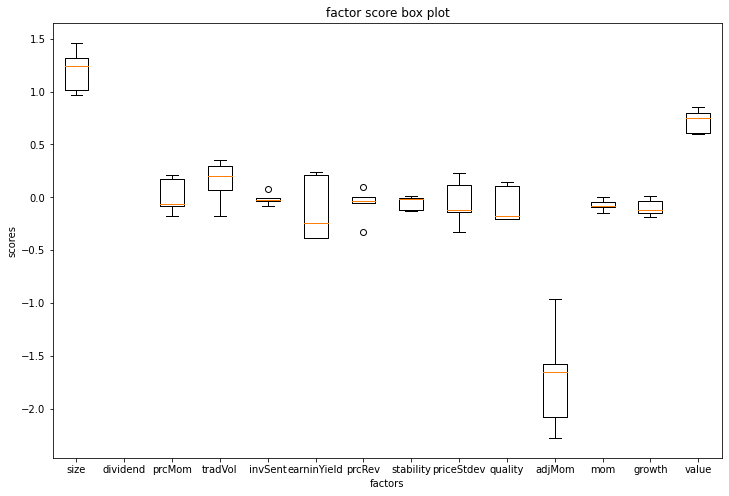

In [223]:
fig, ax1=plt.subplots(figsize=(12, 8))

plt.boxplot(factor_score_res, labels=factor_score_res.columns)

plt.xlabel('factors')
plt.ylabel('scores')
plt.title('factor score box plot')
plt.show()

In [ ]:
factor_res